In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('synthetic_dns_traffic_data.csv')
df.head()

,Timestamp,Query Volume,Query Rate,Query Type,Query Domain,Response Time,TTL Value,Source IP Address,Destination IP Address,Transaction ID,Query Size,Response Size,Entropy of Transaction ID,Frequency of Query Domain,Geolocation of Source IP,Anomaly Label
0,2024-12-10 13:00:00,61,2.87,MX,example.com,0.02,168,192.168.104.92,10.0.112.76,12256,45,391,0.53,83,AU,0
1,2024-12-10 13:01:00,299,1.06,CNAME,example.com,0.05,400,192.168.110.239,10.0.176.90,54176,24,494,0.69,85,DE,0
2,2024-12-10 13:02:00,108,4.33,AAAA,example.com,0.04,147,192.168.126.50,10.0.220.134,44551,45,214,0.57,6,DE,0
3,2024-12-10 13:03:00,163,4.94,NS,domain.edu,0.10,133,192.168.59.241,10.0.221.6,25680,21,294,0.65,69,US,0
4,2024-12-10 13:04:00,161,4.52,AAAA,sample.net,0.09,325,192.168.108.95,10.0.23.3,12610,41,288,0.85,59,AU,0



# Exploring Data

In [2]:
df.describe()

,Query Volume,Query Rate,Response Time,TTL Value,Transaction ID,Query Size,Response Size,Entropy of Transaction ID,Frequency of Query Domain,Anomaly Label
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,174.919000,2.533244,0.054534,350.167400,54806.978200,35.032800,302.545100,0.748134,50.646500,0.100300
std,72.129289,1.406748,0.026387,144.788463,25893.498043,8.888657,115.309259,0.144581,28.890898,0.300415
min,50.000000,0.100000,0.010000,100.000000,10007.000000,20.000000,100.000000,0.500000,1.000000,0.000000
25%,113.000000,1.320000,0.030000,225.000000,32452.500000,27.000000,203.000000,0.620000,26.000000,0.000000
50%,173.000000,2.500000,0.050000,350.000000,54750.500000,35.000000,303.000000,0.750000,51.000000,0.000000
75%,237.000000,3.740000,0.080000,475.000000,77028.750000,43.000000,402.000000,0.870000,75.000000,0.000000
max,300.000000,5.000000,0.100000,600.000000,99999.000000,50.000000,500.000000,1.000000,100.000000,1.000000


In [3]:
print(df.shape)
df.columns

(10000, 16)


Index(['Timestamp', 'Query Volume', 'Query Rate', 'Query Type', 'Query Domain',
       'Response Time', 'TTL Value', 'Source IP Address',
       'Destination IP Address', 'Transaction ID', 'Query Size',
       'Response Size', 'Entropy of Transaction ID',
       'Frequency of Query Domain', 'Geolocation of Source IP',
       'Anomaly Label'],
      dtype='object')

Checking null values

In [4]:
df.isnull().sum().max()

0

class imbalance

Text(0.5, 1.0, 'Class Distributions \n (0: Normal || 1: Anomaly)')

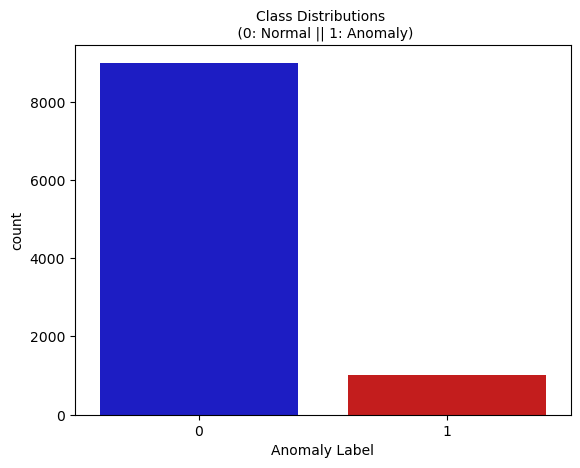

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

colors = ["#0101DF", "#DF0101"]

sns.countplot(x='Anomaly Label', data=df, palette=colors)
plt.title('Class Distributions \n (0: Normal || 1: Anomaly)', fontsize=10)

# Data Transformation

In [6]:
df.dtypes

Timestamp                     object
Query Volume                   int64
Query Rate                   float64
Query Type                    object
Query Domain                  object
Response Time                float64
TTL Value                      int64
Source IP Address             object
Destination IP Address        object
Transaction ID                 int64
Query Size                     int64
Response Size                  int64
Entropy of Transaction ID    float64
Frequency of Query Domain      int64
Geolocation of Source IP      object
Anomaly Label                  int64
dtype: object

Encoding categorical features

In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['Query Type'] = label_encoder.fit_transform(df['Query Type'])
df['Query Domain'] = label_encoder.fit_transform(df['Query Domain'])
df['Source IP Address'] = label_encoder.fit_transform(df['Source IP Address'])
df['Destination IP Address'] = label_encoder.fit_transform(df['Destination IP Address'])
df['Geolocation of Source IP'] = label_encoder.fit_transform(df['Geolocation of Source IP'])
df.head()

,Timestamp,Query Volume,Query Rate,Query Type,Query Domain,Response Time,TTL Value,Source IP Address,Destination IP Address,Transaction ID,Query Size,Response Size,Entropy of Transaction ID,Frequency of Query Domain,Geolocation of Source IP,Anomaly Label
0,2024-12-10 13:00:00,61,2.87,3,1,0.02,168,299,600,12256,45,391,0.53,83,0,0
1,2024-12-10 13:01:00,299,1.06,2,1,0.05,400,507,3110,54176,24,494,0.69,85,2,0
2,2024-12-10 13:02:00,108,4.33,1,1,0.04,147,1123,4921,44551,45,214,0.57,6,2,0
3,2024-12-10 13:03:00,163,4.94,4,0,0.10,133,7655,4985,25680,21,294,0.65,69,4,0
4,2024-12-10 13:04:00,161,4.52,1,2,0.09,325,424,5320,12610,41,288,0.85,59,0,0


split features and Target class

In [8]:
features = df.drop(columns=['Timestamp', 'Anomaly Label'])
target = df['Anomaly Label']

# Data balancing

In [9]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(features, target)

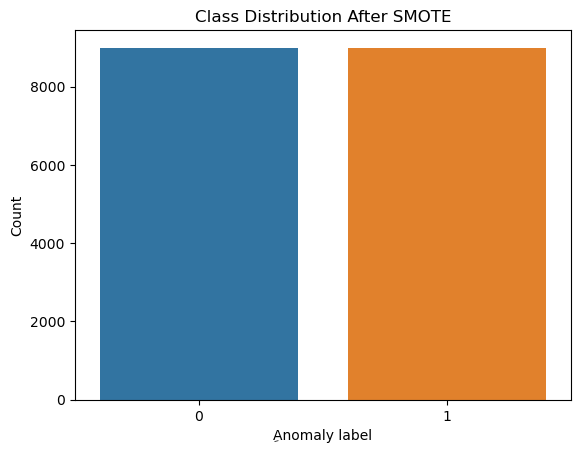

In [10]:
sns.countplot(x=y_resampled)
plt.title('Class Distribution After SMOTE')
plt.xlabel('ِAnomaly label')
plt.ylabel('Count')
plt.show()

Data split for training & testing

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train model

Model: Random Forest
Accuracy: 0.8971936649069185
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1795
           1       0.92      0.87      0.89      1804

    accuracy                           0.90      3599
   macro avg       0.90      0.90      0.90      3599
weighted avg       0.90      0.90      0.90      3599



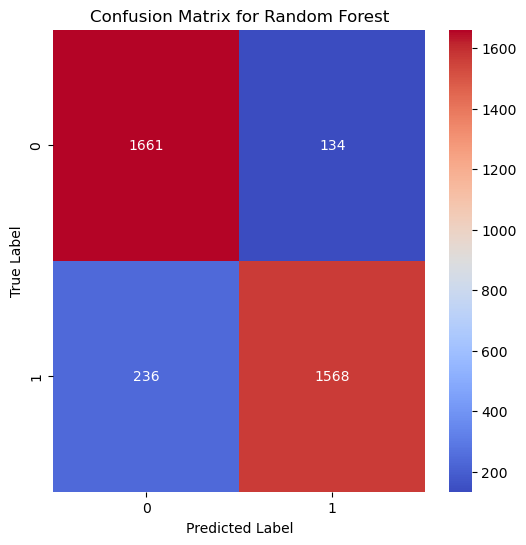

Model: Gradient Boosting
Accuracy: 0.8858016115587664
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.99      0.90      1795
           1       0.98      0.78      0.87      1804

    accuracy                           0.89      3599
   macro avg       0.90      0.89      0.88      3599
weighted avg       0.90      0.89      0.88      3599



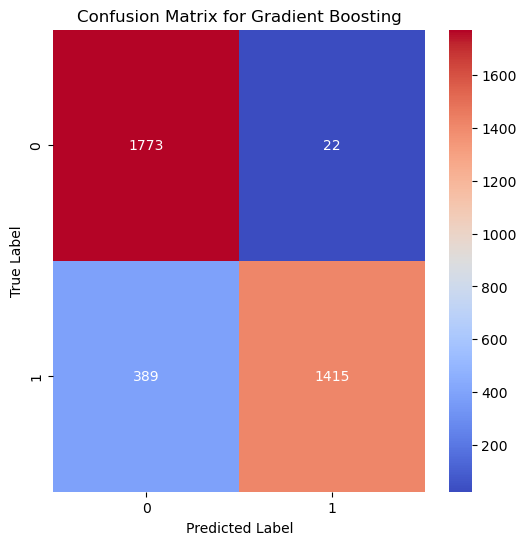

Model: Logistic Regression
Accuracy: 0.5984995832175605
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.58      0.59      1795
           1       0.60      0.61      0.60      1804

    accuracy                           0.60      3599
   macro avg       0.60      0.60      0.60      3599
weighted avg       0.60      0.60      0.60      3599



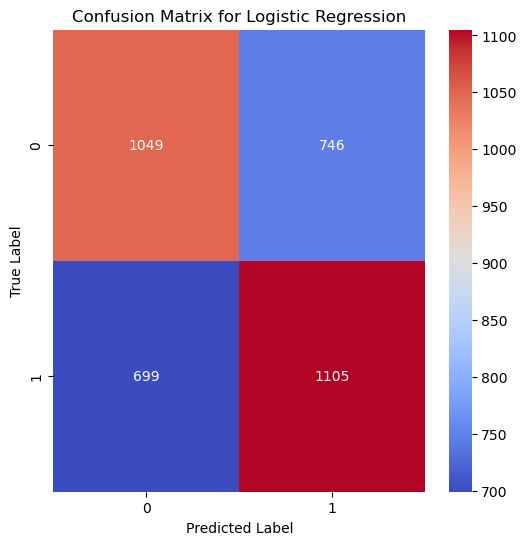

In [39]:
# Train multiple models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)

    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(report)

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion, annot=True, cmap='coolwarm', fmt='d')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    results[model_name] = {
        "accuracy": accuracy,
        "classification_report": report,
        "confusion_matrix": confusion
    }

# Visualization

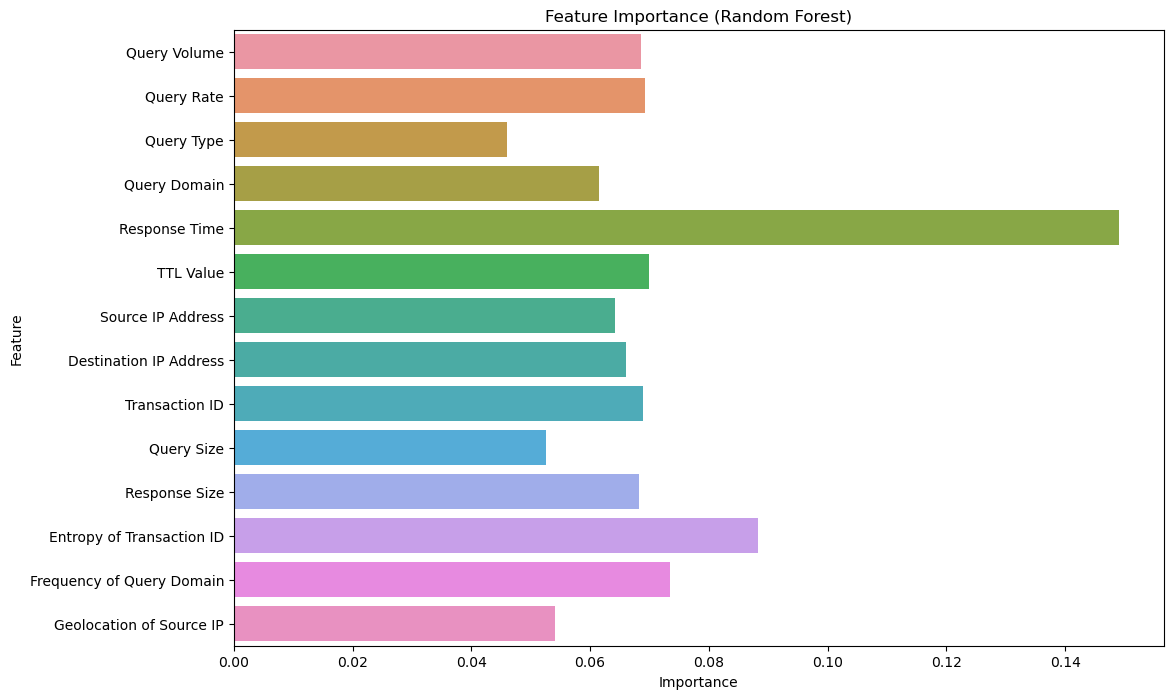

In [35]:
# Plot feature importance from the Random Forest model
feature_importances = models["Random Forest"].feature_importances_
features_list = features.columns

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances, y=features_list)
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


Correlation matrix

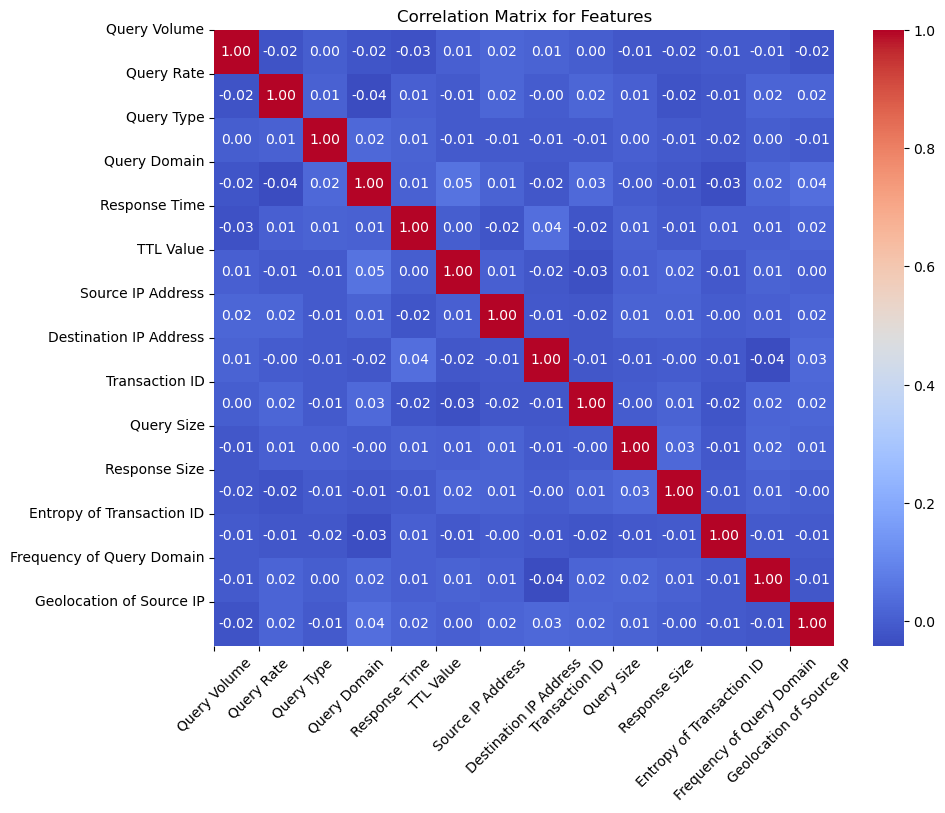

In [40]:
corr = np.corrcoef(X_resampled.T)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, 
            cmap='coolwarm',
            annot=True,
            fmt=".2f")  
plt.xticks(range(len(features.columns)), features.columns, rotation=45)
plt.yticks(range(len(features.columns)), features.columns,rotation=0)
plt.title('Correlation Matrix for Features')
plt.show()